# Character Level RNN for Name classification

This is my implementation of [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) on name classification using Character Level RNN

The goal of the model is given a surname, predict the language of origin (e.g. English, Scottish, German, etc.)

## Dataset

For training the model we will use the we will use the same dataset used in the original tutorial. It can be downloaded from this [link](https://download.pytorch.org/tutorial/data.zip).

Once you download the data, it consists of 18 files named as ```[language].txt``` each file contains a set of names that originated from this language.

<img src="images/languages.PNG" width="200px" />

## Loading the Data

In [1]:
import io
import unicodedata
import string

def unicodeToAscii(s):
    all_letters = string.ascii_letters + ".,;'"
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters)

def readLines(filename):
    lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

In [2]:
import os

categories = []
category_lines = {}

current_path = os.getcwd()
path = os.path.join(current_path, 'data', 'names')
languages = os.listdir(path)

for filename in languages:
    category = os.path.splitext(filename)[0]
    categories.append(category)
    lines = readLines(os.path.join(current_path, 'data', 'names', filename))
    category_lines[category] = lines

The datastructure ```caterorgy_lines``` is a dictionary that maps each language to a list of names.

In [3]:
# sample names
category_lines['Arabic'][:7]

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges']

In [4]:
import numpy as np
X = []
y = []

for cat, names in category_lines.items():
    for name in names:
        X.append(name)
        y.append(cat)  

X = np.array(X)
y = np.array(y)

In [5]:
# size of the dataset
X.shape

(20074,)

## Feature Representation

The next step is to turn each name into a Tensor. Each character is  represented using one hot encoding and the word is a matrix that contains all the vectors of the individual characters.

In [6]:
import torch

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

def letterToVector(letter):
    tensor = torch.zeros(n_letters)
    letterIdx = all_letters.find(letter)
    tensor[letterIdx] = 1
    return tensor

def nameToTensor(name):
    tensor = torch.zeros(len(name), n_letters)
    for  idx, c in enumerate(name):
        tensor[idx] = letterToVector(c)
    return tensor.unsqueeze(1)

## Train Test Split

In [7]:
import numpy as np
def train_test_split(data, labels, test_size=0.2, random_state=0):
    np.random.seed(random_state)
    N = labels.shape[0]
    idx = np.random.permutation(N)
    train_size = int(np.ceil((1-test_size)*N))
    X_train = data[idx[:train_size]]
    y_train = labels[idx[:train_size]]
    X_test = data[idx[train_size:]]
    y_test = labels[idx[train_size:]]
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=113)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (16060,)
X_test shape: (4014,)
y_train shape: (16060,)
y_test shape: (4014,)


## Building the Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.input_to_hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_to_output = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined_state = torch.cat((input, hidden), 1)
        hidden = self.input_to_hidden(combined_state)
        output = self.input_to_output(combined_state)
        output = self.softmax(output)
        return output, hidden

In [11]:
n_hidden = 128

In [24]:
model = RNN(n_letters, n_hidden, len(categories))
model

RNN(
  (input_to_hidden): Linear(in_features=184, out_features=128, bias=True)
  (input_to_output): Linear(in_features=184, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

## Train the model

we will use the negative likelihood loss and the adam optimizer

In [25]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

we will use a custom dataset to split the data into batches where each batch is a single name

In [26]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [27]:
class ListDataset(Dataset):
    
    def __init__(self, *lists):
        self.lists = lists

    def __getitem__(self, index):
        return tuple(lst[index] for lst in self.lists)

    def __len__(self):
        return len(self.lists[0])

In [28]:
train_data = ListDataset(X_train, y_train)
val_data = ListDataset(X_test, y_test)
train_dataloader = DataLoader(dataset=train_data, batch_size=1)
val_dataloader = DataLoader(dataset=val_data, batch_size=1)
dataloaders = {'train': train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train': len(X_train), 'val': len(X_test)}

In [29]:
import time
def train_model(model, criterion, optimizer, dataset_sizes, bs, num_epochs):
    
    since = time.time()
    epoch_loss = []
    epoch_acc = []

    print_every = int((dataset_sizes['train']/bs)/10)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            i = 0
            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'train':
                 print(f'\rProgress:',end='')
                    
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                 #initialize the hidden state
                hidden = torch.zeros(1, n_hidden)
                
                
                input_tensor = nameToTensor(inputs[0])
                label_tensor = torch.tensor([categories.index(labels[0])], dtype=torch.long) 

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                     
                    for ix in range(input_tensor.size()[0]):
                        output, hidden = model(input_tensor[ix], hidden)
                    
                    _, preds = torch.max(output, 1)
                    loss = criterion(output, label_tensor)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                
                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == label_tensor.data)
               
                if phase == 'train' and i % print_every == print_every - 1:
                    print(f"\rProgress: [{'='*((i+1)//print_every)}] ",end='')
                          
               
                i += 1  
                
            epoch_loss.append(running_loss / dataset_sizes[phase])
            epoch_acc.append(running_corrects.numpy() / dataset_sizes[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss[-1], epoch_acc[-1]))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_loss, epoch_acc

In [30]:
epoch_loss, epoch_acc = train_model(model, criterion, optimizer, dataset_sizes,bs=1, num_epochs=8)

Epoch 0/7
----------
Progress: [==========] train Loss: 1.1802 Acc: 0.6504
val Loss: 0.9779 Acc: 0.7040

Epoch 1/7
----------
Progress: [==========] train Loss: 0.9365 Acc: 0.7113
val Loss: 0.9092 Acc: 0.7192

Epoch 2/7
----------
Progress: [==========] train Loss: 0.8791 Acc: 0.7257
val Loss: 0.8817 Acc: 0.7270

Epoch 3/7
----------
Progress: [==========] train Loss: 0.8552 Acc: 0.7321
val Loss: 0.8895 Acc: 0.7302

Epoch 4/7
----------
Progress: [==========] train Loss: 0.8389 Acc: 0.7368
val Loss: 0.8654 Acc: 0.7394

Epoch 5/7
----------
Progress: [==========] train Loss: 0.8249 Acc: 0.7415
val Loss: 0.8664 Acc: 0.7427

Epoch 6/7
----------
Progress: [==========] train Loss: 0.8174 Acc: 0.7415
val Loss: 0.8363 Acc: 0.7466

Epoch 7/7
----------
Progress: [==========] train Loss: 0.8086 Acc: 0.7457
val Loss: 0.8339 Acc: 0.7491

Training complete in 19m 1s


In [23]:
torch.save(model.state_dict(), "model.h5")

In [19]:
model.load_state_dict(torch.load("model.h5"))

<All keys matched successfully>

our model got 74.57% accuracy on the training dataset and 74.91% accuracy on the validation dataset. we can plot a graph of the loss and learning rate as they progress over the epochs. 

In [35]:
import matplotlib.pyplot as plt

In [36]:
# plot loss
accuracy = epoch_acc[::2]
val_accuracy = epoch_acc[1::2]
loss = epoch_loss[::2]
val_loss = epoch_loss[1::2]

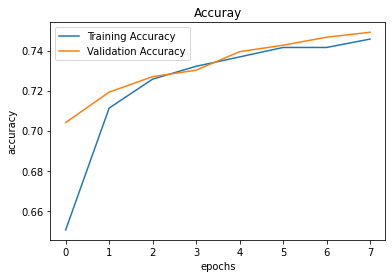

In [37]:
#plot accuracy
plt.figure()
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.title('Accuray')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

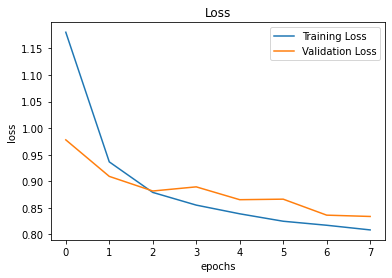

In [38]:
#plot loss
plt.figure()
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()